# ***Unsupervised learning using RGB image data***
#### Author(s): Peng, Miller
#### Previous Edit: 2022-Mar-6


In [1]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

import os
import time
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from IPython.display import clear_output

In [10]:
# Define global variables for the notebook
##################################
# Define if GPU is used
use_cuda = False

# Main working directory containing all the output files in this notebook
# Bald Mountain\Top Pit\2021_BM_Top
# Gold Bar\Pick Pit\2021_GB_Pick_E-Top
main_dir = os.path.join(os.getcwd(), r'Gold Bar\Pick Pit\2021_GB_Pick_E-Top')

# Name of the training tensor file
# train_tensors_x_sample
# train_tensors_x_E-Top
dat_name = 'train_tensors_192_E-Top.pt'

# Name of the tensor file used to add more training samples
aug_name = 'train_tensors_384_E-Top.pt'
##################################

# Add a suffix to file names based on training tensor file name
try:
    int(dat_name.split('_')[-1].split('.')[0])
except:
    suffix = '_' + dat_name.split('_')[-1].split('.')[0]
else:
    suffix = ""

## First Time Preparations

In [5]:
# def first_time_prep(train_dir, im_name = None):
#     """
#     Description: 
#         Creates a torch tensor file of all the training data    
    
#     Args:
#         train_dir: Directory containing the training images
#         im_name: Name of the sample training images (including file extension)
        
#     Outputs:
#         None

#     """
#     # Show the first training sample
#     if im_name:
#         with Image.open(os.path.join(train_dir, im_name)) as image:
#             plt.imshow(image)
    
#     # Import training data (For creating Pytorch tensors)
#     train_data = []
#     i = 0
#     for fname in os.listdir(train_dir):
#         with Image.open(os.path.join(train_dir, fname)) as im: 
#             imarray = np.array(im)
#         train_data.append(imarray)
#         i += 1
#         if i % 5000 == 0:
#             print('{} images imported...'.format(i)) # Track progress
            
#     print('Total of {} images imported'.format(len(train_data)))
    
#     # Transform training data to Pytorch tensor  
#     train_data = torch.tensor(np.array(train_data)).float()
#     print('Training data shape: ', train_data.shape)
    
#     # Save training tensors to file
#     torch.save(train_data, os.path.join(main_dir, dat_name))
    
#     print('First time preparation complete')

# ##################################
# # Data directory
# train_dir = os.path.join(os.path.dirname(os.getcwd()), r'Data\Unlabelled\2021_BM_Top_96_sample')
# ##################################

# first_time_prep(train_dir = train_dir, im_name = None)

Total of 4680 images imported
Training data shape:  torch.Size([4680, 96, 96, 3])
First time preparation complete


## Data Loading & Preprocessing 

***IMPORTANT!!! If one normalizes the training set by transforming the data to become zero mean and unit standard deviation, during test time or prediction, the mean and stdev from the TRAINING set (notice: NOT the test set) should be used to normalize the test data before sending them into the network! This is because the model is trained according to the training set. In other words, it somehow requires that your training set is relatively representative of the data on which the model will be tested!***

In [3]:
def data_aug(train_data, dim, angle = 0, num = 0):
    """
    Description:
        Increase the number of training samples through data augmentation. 
        Methods: 
            1. tiles of a greater size will be randomly cropped to the desired tile size
            2. tiles of a greater size will be rotated and then centre-cropped to the desire tile size
    
    Args:
        train_data: Original training data (Pytorch tensor)
        dim: The dimension of the crop (int)
        angle: The angle in degrees to rotate the larger tile size before centre-cropping (number)
        num: Number of randomly cropped tiles created for each input tile (int)
    
    Outputs:
        train_data: New training data containing the augmented data (Pytorch tensor) 
        
    """

    # Load larger tile size data to be used to increase sample count
    data = torch.load(os.path.join(main_dir, aug_name)) # (N, H, W, C)  
    data = data.permute((0, 3, 1, 2)) # Change dimension order to [N, C, H, W]
    if num != 0 or angle != 0:
        print('Augmenting using larger tile', data.shape)
    
    # Ensure the cropped tile size is smaller than the larger tile size data
    assert dim < data.shape[-1], 'The crop dimension needs to be smaller than the tile size'
    
    # Randomly crop from a larger tile size 
    if num != 0:
        print('Randomly cropping {} times'.format(num))
        transform_crop = transforms.RandomCrop(size = (dim, dim))
        for i in range(num):
            cropped = transform_crop(data)
            train_data = torch.cat([train_data, cropped], axis = 0) # (N*, C, H, W)
    
    # Rotate a larger tile size and then centre-crop it
    if angle != 0:
        print('Rotating {} degrees and then centre-cropping'.format(angle))
        rotated = transforms.functional.rotate(data, angle = angle)
        train_data = torch.cat([train_data, transforms.functional.center_crop(rotated, dim)], axis = 0) # (N*, C, H, W)
    
    print('Complete\n')
    
    return train_data

In [3]:
def load_and_preproc(norm, rotate_crop_angle = 0, num_rand_crop = 0):
    """
    Description: 
        Load training data and preprocess them with optional augmentation
    
    Args:
        norm: Whether to normalize the data (bool)
        rotate_crop_angle: The angle in degrees to rotate the larger tile size before centre-cropping (number)
        num_rand_crop: Number of randomly cropped tiles created for each larger tile (int)   
    
    Outputs:
        train_data: Preprocessed training data (Pytorch tensor)
        mean: Mean values of the three channels
        std: Standard deviation values of the three channels
    
    """
    # Load saved training tensors file
    train_data_raw = torch.load(os.path.join(main_dir, dat_name)) # (N, H, W, C)
    print('Raw training data shape: ', train_data_raw.shape)
    
    # Change dimension order to [N, C, H, W]
    train_data = train_data_raw.permute((0, 3, 1, 2)) # (N, C, H, W)
    
    # Augment data by creating more training data
    if (num_rand_crop or rotate_crop_angle) != 0: 
        train_data = data_aug(train_data, 
                              dim = train_data.shape[-1], 
                              angle = rotate_crop_angle, 
                              num = num_rand_crop)
    
    # Calculate mean and std. dev. and normalize the data by them
    if norm:
        mean, std = train_data.mean([0, 2, 3]), train_data.std([0, 2, 3])
        print('Mean values of the three channels are: {}'.format(mean))
        print('Stdev values of the three channels are: {}\n'.format(std))

        transform_norm = transforms.Compose([transforms.Normalize(mean, std)])
        train_data = transform_norm(train_data) # (N, C, H, W)        
        print('Mean values of the three channels after input normalization are: {}'.format(train_data.mean([0,2,3])))
        print('Stdev values of the three channels after input normalization are: {}\n'.format(train_data.std([0,2,3])))  
    
    print('Final training data shape: ', train_data.shape)
    print('Data loading and preprocessing complete')
    
    return train_data, mean, std

In [5]:
# Load the data
train_data, mean, std = load_and_preproc(norm = True, 
                                         rotate_crop_angle = 30,
                                         num_rand_crop = 6)

Raw training data shape:  torch.Size([611, 256, 256, 3])
Augmenting using larger tile torch.Size([248, 3, 384, 384])
Randomly cropping 6 times
Rotating 30 degrees and then centre-cropping
Complete

Mean values of the three channels are: tensor([128.9115, 117.2373, 104.4721])
Stdev values of the three channels are: tensor([21.8064, 22.1712, 21.8797])

Mean values of the three channels after input normalization are: tensor([ 2.8063e-07,  1.3464e-07, -3.0739e-07])
Stdev values of the three channels after input normalization are: tensor([1.0000, 1.0000, 1.0000])

Final training data shape:  torch.Size([2347, 3, 256, 256])
Data loading and preprocessing complete


In [ ]:
# print(torch.max(train_data), torch.min(train_data))

In [ ]:
# # This cell demonstrates that the MSE loss is already an averaged loss value (delete this cell later)
# a = torch.ones(10,3,5,5).clone().detach()
# b = torch.zeros(10,3,5,5)
# print(a)
# print(b)
# print('---'*10)
# print(torch.nn.MSELoss()(a,b)) # the output is 1, meaning that the MEAN squared loss between the two tensors is 1

## Define the network architecture

### Model architecture 1

In [2]:
class Autoencoder_FConv(torch.nn.Module):
    def __init__(self, in_shape = (3,32,32), num_filters = 16, embed_dim = 128, seed = 0):
        super(Autoencoder_FConv, self).__init__()
        torch.manual_seed(seed)
        self.name = 'MT'
        
        in_channels, H, W = in_shape # The H and W are only for decoder, not for encoder 
        self.in_channels = in_channels # Record the number of input channels
        
        # Define the encoder (C = num_filters)
        self.encoder = torch.nn.Sequential(
            # Same Conv [N, C, H, W]
            nn.Conv2d(in_channels = in_channels, out_channels = num_filters, kernel_size = 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),            
            # Same Conv [N, C, H, W]
            nn.Conv2d(in_channels = num_filters, out_channels = num_filters, kernel_size = 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(num_filters, 2*num_filters, 3, stride = 2, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(2*num_filters, 4*num_filters, 3, stride = 2, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(4*num_filters, 8*num_filters, 3, stride = 2, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d((1,1)), # Global avg pooling makes the network for all input sizes -> [N, 8*C, 1, 1]
            nn.Flatten(), # [N, 8*C]
            nn.Linear(8*num_filters, embed_dim), # [N, embed_dim]
        ) # End of definition of encoder
        
        
        # Define the decoder (decoder is only used in the training process)
        # Linear decoding
        self.lin_unflatten = torch.nn.Sequential(            
            nn.Linear(embed_dim, 8*num_filters * H//8 * W//8),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size = (8*num_filters, H//8, W//8)), # [N, 8*C, H//8, W//8]
        )
        
        self.decoder = torch.nn.Sequential(
#             nn.Conv2d(8*num_filters, 8*num_filters, 3, stride=1, padding=1), # [N,8*C,H//8,W//8]
#             nn.BatchNorm2d(8*num_filters),
#             nn.ReLU(),
            
            # Upsample [N, 4*C, H//4, W//4]
            nn.ConvTranspose2d(8*num_filters, 4*num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
#             nn.Conv2d(4*num_filters, 4*num_filters, 3, stride=1, padding=1), # [N,4*C,W//4,H//4]
#             nn.BatchNorm2d(4*num_filters),
#             nn.ReLU(),
            
            # Upsample [N, 2*C, H//2, W//2]
            nn.ConvTranspose2d(4*num_filters, 2*num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
#             nn.Conv2d(2*num_filters, 2*num_filters, 3, stride=1, padding=1), # [N,2*C,W//2,H//2]
#             nn.BatchNorm2d(2*num_filters),
#             nn.ReLU(),
            
            # Upsample [N, C, H, W]
            nn.ConvTranspose2d(2*num_filters, num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            
#             nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1), # [N,C,W,H]
#             nn.BatchNorm2d(num_filters),
#             nn.ReLU(),
            
            # 1-by-1 conv [N, 3, H, W]
            nn.Conv2d(in_channels = num_filters, out_channels = 3,  kernel_size = 1, stride = 1, padding = 0) 
        ) # End of definition of decoder
        
        
    def forward(self, x):
        # Encode
        embedding = self.encoder(x.float().contiguous()) # [N, embed_dim]
        
        # Decode
        x = self.lin_unflatten(embedding) # [N, 8*num_filters, H//8, W//8]
        x = self.decoder(x) # [N, in_channels, H, W]
        return x, embedding        

In [ ]:
# net =  Autoencoder_FConv(in_shape = (3, 128, 128), embed_dim = 128)
# print(net)

# a = torch.rand(100, 3, 128, 128)
# b1, b2 = net(a)

# print(b1.shape)
# print(b2.shape)

In [10]:
from torchinfo import summary
summary(Autoencoder_FConv(in_shape = (3, 256, 256), embed_dim = 128), input_size = (1, 3, 256, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_FConv                        --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 256, 256]         32
│    └─ReLU: 2-3                         [1, 16, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 16, 256, 256]         2,320
│    └─BatchNorm2d: 2-5                  [1, 16, 256, 256]         32
│    └─ReLU: 2-6                         [1, 16, 256, 256]         --
│    └─Conv2d: 2-7                       [1, 32, 128, 128]         4,640
│    └─BatchNorm2d: 2-8                  [1, 32, 128, 128]         64
│    └─ReLU: 2-9                         [1, 32, 128, 128]         --
│    └─Conv2d: 2-10                      [1, 32, 128, 128]         9,248
│    └─BatchNorm2d: 2-11                 [1, 32, 128, 128]         64
│    

### Model architecture 2

In [11]:
class Autoencoder_FConv_Sym(torch.nn.Module):
    def __init__(self, in_shape = (3,32,32), num_filters = 16, embed_dim = 128, seed = 0):
        super(Autoencoder_FConv_Sym, self).__init__()
        torch.manual_seed(seed)
        self.name = 'PY'
        
        in_channels, H, W = in_shape # The H and W are only for decoder, not for encoder 
        self.in_channels = in_channels # Record the number of input channels
        
        # Define the encoder (C = num_filters)
        self.encoder = torch.nn.Sequential(
            # Same Conv [N, C, H, W]
            nn.Conv2d(in_channels = in_channels, out_channels = num_filters, kernel_size = 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),            
            # Same Conv [N, C, H, W]
            nn.Conv2d(in_channels = num_filters, out_channels = num_filters, kernel_size = 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(num_filters, 2*num_filters, 3, stride = 2, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), # [N, 2*C, H//2, W//2]
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(2*num_filters, 4*num_filters, 3, stride = 2, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1), # [N, 4*C, H//4, W//4]
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
            # Downsample
            nn.Conv2d(4*num_filters, 8*num_filters, 3, stride = 2, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            # Same Conv
            nn.Conv2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), # [N, 8*C, H//8, W//8]
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d((1,1)), # Global avg pooling makes the network for all input sizes -> [N, 8*C, 1, 1]
            nn.Flatten(), # [N, 8*C]
            nn.Linear(8*num_filters, embed_dim), # [N, embed_dim]
        ) # End of definition of encoder
        
        
        # Define the decoder (decoder is only used in the training process)
        # Decoder is symmetrical w.r.t. encoder
        # Linear decoding
        self.lin_unflatten = torch.nn.Sequential(            
            nn.Linear(embed_dim, 8*num_filters * H//8 * W//8),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size = (8*num_filters, H//8, W//8)), # [N, 8*C, H//8, W//8]
        )
        
        self.decoder = torch.nn.Sequential(
            # Same Conv [N, 8*C, H//8, W//8]
            nn.ConvTranspose2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 8*C, H//8, W//8]
            nn.ConvTranspose2d(8*num_filters, 8*num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(8*num_filters),
            nn.ReLU(),
            
            # Upsample [N, 4*C, H//4, W//4]
            nn.ConvTranspose2d(8*num_filters, 4*num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 4*C, H//4, W//4]
            nn.ConvTranspose2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 4*C, H//4, W//4]
            nn.ConvTranspose2d(4*num_filters, 4*num_filters, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU(),
            
            # Upsample [N, 2*C, H//2, W//2]
            nn.ConvTranspose2d(4*num_filters, 2*num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 2*C, H//2, W//2]
            nn.ConvTranspose2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 2*C, H//2, W//2]
            nn.ConvTranspose2d(2*num_filters, 2*num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            
            # Upsample [N, C, H, W]
            nn.ConvTranspose2d(2*num_filters, num_filters, 3, stride = 2, padding = 1, output_padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            
            # Same Conv [N, C, H, W]            
            nn.ConvTranspose2d(num_filters, num_filters, 3, stride = 1, padding = 1), 
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            
            # Same Conv [N, 3, H, W]            
            nn.ConvTranspose2d(num_filters, 3, 3, stride = 1, padding = 1), 
        ) # End of definition of decoder
        
        
    def forward(self, x):
        # Encode
        embedding = self.encoder(x.float().contiguous()) # [N, embed_dim]
        
        # Decode
        x = self.lin_unflatten(embedding) # [N, 8*num_filters, H//8, W//8]
        x = self.decoder(x) # [N, in_channels, H, W]
        return x, embedding        

In [ ]:
# net =  Autoencoder_FConv_Sym(in_shape = (3, 128, 128), embed_dim = 128)
# print(net)

# a = torch.rand(100, 3, 128, 128)
# b1, b2 = net(a)

# print(b1.shape)
# print(b2.shape)

In [13]:
from torchinfo import summary
summary(Autoencoder_FConv_Sym(in_shape = (3, 256, 256), embed_dim = 128), input_size = (1, 3, 256, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_FConv_Sym                    --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 256, 256]         32
│    └─ReLU: 2-3                         [1, 16, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 16, 256, 256]         2,320
│    └─BatchNorm2d: 2-5                  [1, 16, 256, 256]         32
│    └─ReLU: 2-6                         [1, 16, 256, 256]         --
│    └─Conv2d: 2-7                       [1, 32, 128, 128]         4,640
│    └─BatchNorm2d: 2-8                  [1, 32, 128, 128]         64
│    └─ReLU: 2-9                         [1, 32, 128, 128]         --
│    └─Conv2d: 2-10                      [1, 32, 128, 128]         9,248
│    └─BatchNorm2d: 2-11                 [1, 32, 128, 128]         64
│    

Note:  the encoder can take various size input while the number of encoder parameters remains the same since the network is fully convolutional, but the decoder's dimension will depend on the training sample's height and width. However, it does not matter what the decoder dimension is during the clustering time because we will not use the decoder in the clustering process.

## Define the training function

In [8]:
# Training function 
def train(model, data, params_file, get_loss, num_epochs = 1, batch_size = 128, learning_rate = 0.001):
    """
    Description:
        Model training function
    
    Args:
        model: The model to be trained
        data: The training data (Pytorch tensor)
        params_file: The name of the model weights file  
        get_loss: Whether to return the loss values (bool)
        num_epochs: The number of epochs to train
        batch_size: The number of samples per batch
        learning_rate: The learning rate
    
    Outputs:
        outputs: The reconstructed imgs (list of Pytorch tensor)
        embed: The embeddings of the imgs (Pytorch tensor (N, embed_dim))
        losses: loss per iteration (list)
        epoch_losses: loss per epoch (list)        
    """
    
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size = batch_size, 
                                               shuffle = True)
    
    outputs, iters, losses, epoch_losses = [], [], [], []
    n = 0 # Number of total iterations
    i = 0 # Number of iterations per epoch
    
    for epoch in range(num_epochs):
        tic = time.time() # Track run-time for each epoch
        
        for img in train_loader:
            if use_cuda and torch.cuda.is_available(): # GPU
                img = img.cuda()
            recon, embed = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            iters.append(n)
            losses.append(float(loss))
            n += 1
            i += 1
        
        epoch_losses.append(sum(losses[ (n - i):(n) ]) / i) # Compute average loss per epoch
        print('Epoch:{}, Loss:{:.5f}, time (s):{:.2f}'.format(epoch + 1, 
                                                              float(epoch_losses[epoch]), 
                                                              time.time() - tic))            
        outputs.append(recon,)   
        i = 0
        
        # Save weights every 25 epoch
        if (epoch + 1) % 25 == 0:
            torch.save(model.state_dict(), params_file[:-3] + '_chkpt.pt')     

    # Save the final model weights
    torch.save(model.state_dict(), params_file) 
    
    if get_loss:
        return outputs, embed, losses, epoch_losses
    else:
        return outputs, embed

## Sanity check 

In [ ]:
# # Work with small sample first to test
# subset = torch.utils.data.DataLoader(train_data, 
#                                      batch_size = 20, 
#                                      shuffle = False)
# subset_iter = iter(subset)
# images = subset_iter.next()
# print(images.shape)

In [ ]:
# net = Autoencoder_FConv_Sym(in_shape = (3, 128, 128), num_filters = 16, embed_dim = 128, seed = 0)

# if use_cuda and torch.cuda.is_available():
#     net.cuda()
#     print('CUDA is available! Training on GPU ...')
# else:
#     print('CUDA is unavailable. Training on CPU ...')  

# tic = time.time()
# outputs, embed = train(net, images, # subset 
#                 num_epochs = 300, 
#                 batch_size = 20, # subset length
#                 learning_rate = 0.001)
# print('Total run-time: {:.2f}'.format(time.time() - tic))

## Start training the model

In [9]:
# Setting up for training and training curve plot
##################################
# Retraining in same or different session (dictates if saved files or loaded or not)
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
diff_retrain_sess = False # Set as False if training from scratch

# Model architectural parameters
in_shape = (3, 256, 256)
num_filters = 16
embed_dim = 128
seed = 1337

# Hyperparameters
batch_size = 16
learning_rate = 0.0001

# Model architecture
model_name = 'PY'
##################################

if model_name == 'MT': # Model 1
    fpath = os.path.join(main_dir, 'Model_MT_Outputs') # Path of the output folder 
    model = Autoencoder_FConv(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)
elif model_name == 'PY': # Model 2
    fpath = os.path.join(main_dir, 'Model_PY_Outputs') # Path of the output folder 
    model = Autoencoder_FConv_Sym(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)    

# Name of model weights file and path
params_file = fpath + '\Model_{0}_dim{1}_emb{2}_f{3}_s{4}_bs{5}_lr{6}{7}.pt'.format(model.name, 
                                                                             in_shape[-1], 
                                                                             embed_dim,  
                                                                             num_filters,  
                                                                             seed,  
                                                                             batch_size,
                                                                             learning_rate,
                                                                             suffix)
# Load partially trained model for continuing training
if diff_retrain_sess:    
    model.load_state_dict( torch.load(params_file) ) 
    print('Previously trained model loaded')
    
# Keep track of losses and time especially during model retraining
tot_i_losses, tot_e_losses = [], []
tot_run_time = 0

# Print information
print('Using model', model_name)
print('Output directory:')
print('\t' + fpath)
print('Model parameters file:')
print('\t' + params_file)

Using model PY
Output directory:
	D:\PYang\BM_GB_21\Unsupervised Learning\Gold Bar\Pick Pit\2021_GB_Pick_E-Top\Model_PY_Outputs
Model parameters file:
	D:\PYang\BM_GB_21\Unsupervised Learning\Gold Bar\Pick Pit\2021_GB_Pick_E-Top\Model_PY_Outputs\Model_PY_dim256_emb128_f16_s1337_bs16_lr0.0001_E-Top.pt


In [14]:
# Start training
##################################
num_epochs = 25 # Change
##################################

if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available! Training on GPU ...')
else:
    print('CUDA is unavailable. Training on CPU ...')   

tic = time.time()
outputs, embed, i_loss, e_loss = train(model, 
                                        train_data, 
                                        num_epochs = num_epochs, 
                                        batch_size = batch_size, 
                                        learning_rate = learning_rate,
                                        params_file = params_file,
                                        get_loss = True)
run_time = time.time() - tic
print('Training Run-time: {:.2f} seconds'.format(run_time))

CUDA is available! Training on GPU ...
Epoch:1, Loss:0.08789, time (s):12.35
Epoch:2, Loss:0.08809, time (s):12.03
Epoch:3, Loss:0.08775, time (s):12.00
Epoch:4, Loss:0.08694, time (s):12.01
Epoch:5, Loss:0.08714, time (s):12.00
Epoch:6, Loss:0.08514, time (s):12.02
Epoch:7, Loss:0.08804, time (s):12.00
Epoch:8, Loss:0.08655, time (s):12.03
Epoch:9, Loss:0.08391, time (s):12.02
Epoch:10, Loss:0.08497, time (s):12.04
Epoch:11, Loss:0.08531, time (s):12.04
Epoch:12, Loss:0.08540, time (s):12.08
Epoch:13, Loss:0.08272, time (s):12.03
Epoch:14, Loss:0.08387, time (s):12.06
Epoch:15, Loss:0.08266, time (s):12.25
Epoch:16, Loss:0.08128, time (s):12.04
Epoch:17, Loss:0.08336, time (s):12.05
Epoch:18, Loss:0.08603, time (s):12.04
Epoch:19, Loss:0.08312, time (s):12.04
Epoch:20, Loss:0.08164, time (s):12.04
Epoch:21, Loss:0.08137, time (s):12.04
Epoch:22, Loss:0.08069, time (s):12.09
Epoch:23, Loss:0.07963, time (s):12.03
Epoch:24, Loss:0.07863, time (s):12.04
Epoch:25, Loss:0.08204, time (s):1

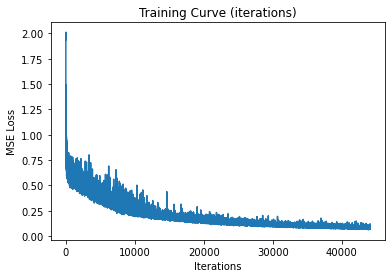

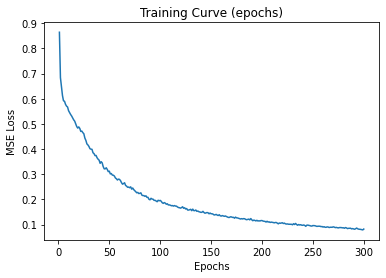

Total run-time: 3631.64 seconds
Total epochs:  300


In [15]:
# Plot training curves
##################################
just_plot = False # Just plot the training curve
##################################

if diff_retrain_sess:
    # Load previously saved losses and run-time files and convert to numbers
    tot_i_losses, tot_e_losses = [], []
    tot_run_time = 0
    
    # Load loss per iteration file
    with open(params_file + '_iloss.txt', 'r') as f: 
        for row in f:
            tot_i_losses.append(float(row.strip()))
        print('iloss loaded')  
            
    # Load loss per epoch file
    with open(params_file + '_eloss.txt', 'r') as f:
        for row in f:
            tot_e_losses.append(float(row.strip()))
        print('eloss loaded')  
    
    # Load total run-time file
    with open(params_file + '_runtime.txt', 'r') as f:
            tot_run_time = float(f.read())
            print('run-time loaded')     
    
    # Add new losses and run-time to old one if retraining
    if just_plot is False:
        tot_i_losses.extend(i_loss)
        tot_e_losses.extend(e_loss) 
        tot_run_time += run_time
            
    diff_retrain_sess = False # Change back to current retraining sesion
    print('diff_retrain_sess is now False')
else: 
    # Keep track of losses and run-time in current training session
    tot_i_losses.extend(i_loss)
    tot_e_losses.extend(e_loss) 
    tot_run_time += run_time

# Training curve by iterations
plt.title("Training Curve (iterations)")
plt.plot(range(1, len(tot_i_losses)+1), tot_i_losses, label = "Train")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()

# Training curve by epochs
plt.title("Training Curve (epochs)")
plt.plot(range(1, len(tot_e_losses)+1), tot_e_losses, label = "Train")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

print('Total run-time: {:.2f} seconds'.format(tot_run_time))
print('Total epochs: ', len(tot_e_losses))

In [16]:
# Save losses and run-time to text file as strings
# Save loss per iteration
if os.path.exists(params_file + '_iloss.txt'):
    print('Warning: iloss file already exists')
else:
    with open(params_file + '_iloss.txt', 'w') as f:
        for i_loss in tot_i_losses:
            f.write(str(i_loss) + '\n')
    print('iloss saved')  

# Save loss per epoch
if os.path.exists(params_file + '_eloss.txt'):
    print('Warning: eloss file already exists')
else:
    with open(params_file + '_eloss.txt', 'w') as f:
        for e_loss in tot_e_losses:
            f.write(str(e_loss) + '\n')
    print('eloss saved')

# Save total run-time
if os.path.exists(params_file + '_runtime.txt'):
    print('Warning: runtime file already exists')
else:
    with open(params_file + '_runtime.txt', 'w') as f:
        f.write(str(tot_run_time))
    print('run-time saved')  

iloss saved
eloss saved
run-time saved


## Create embedding using training data

***Note: If the training data is augmented, only the original (unaugmented) data will be used. Also, the entire orthomosaic is not used***

In [17]:
##################################
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
# Model architectural parameters
in_shape = (3, 256, 256)
num_filters = 16
embed_dim = 128
seed = 1337

# Hyperparameters
batch_size = 16
learning_rate = 0.0001

# Model architecture
model_name = 'PY'
##################################

if model_name == 'MT': # Model 1
    fpath = os.path.join(main_dir, 'Model_MT_Outputs') # Path of the output folder 
    model_final = Autoencoder_FConv(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)
elif model_name == 'PY': # Model 2
    fpath = os.path.join(main_dir, 'Model_PY_Outputs') # Path of the output folder 
    model_final = Autoencoder_FConv_Sym(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)    
print('Using model', model_name)
print('Output directory:')
print(fpath)

Using model PY
Output directory:
D:\PYang\BM_GB_21\Unsupervised Learning\Gold Bar\Pick Pit\2021_GB_Pick_E-Top\Model_PY_Outputs


In [18]:
# Final model
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
params_file = fpath + '\Model_{0}_dim{1}_emb{2}_f{3}_s{4}_bs{5}_lr{6}{7}.pt'.format(model_final.name, 
                                                                             in_shape[-1], 
                                                                             embed_dim,  
                                                                             num_filters,  
                                                                             seed,  
                                                                             batch_size,
                                                                             learning_rate,
                                                                             suffix)

model_final.load_state_dict( torch.load(params_file) ) 
model_final.eval() # Set to evaluation model for prediction at test time
model_final = model_final.cpu() # Use CPU instead of GPU

In [19]:
def create_embed(train_data, model, small_batch, b_size = 2048, get_recon = False):
    """
    Description:
    Create embeddings using a trained model and training data
    
    Args:
    train_data: Training data 
    model: The model to be used for creating the embedding
    small_batch: Whether to use a smaller batch size due to CPU memory limitation (bool)
    b_size: Size of the batch to be used if small_batch is True (int)
    get_recon: Whether to return the reconstructed images (bool)
    
    Outputs:
    recons: Reconstructed image from the model (Pytorch tensor)
    embed: The embeddings of the training data (Numpy array)
    
    """
    
    # First method of creating embedding (memory insufficient)
    if small_batch:
        print('Creating embedding using memory insufficient method...')
        loader = torch.utils.data.DataLoader(train_data, 
                                             batch_size = b_size, # Smaller batch size
                                             shuffle = False) # Order matters
        embed_arr, recons_arr = [], []
        
        # Get reconstruction and embedding
        for img in loader: 
            recons, embed = model(img) # recons: [N, C, H, W]; embed: [N, embed_dims]
            recons_arr.append( recons.cpu().detach().numpy() )
            embed_arr.append( embed.cpu().detach().numpy() )

        # Create a numpy array of shape (N, C, H, W) where N = (len(recons_arr)-1) * batch_size + last batch_size 
        # for the reconstruction since len(recons_arr) == number of times the for loop above ran
        recons = np.asarray(recons_arr[:-1]) # [len(recons_arr)-1, batch_size, C, H, W]
        recons = recons.reshape(-1, recons.shape[2], recons.shape[3], recons.shape[4]) # [N - last batch_size, C, H, W]
        recons = torch.from_numpy(np.concatenate((recons, recons_arr[-1]), axis = 0)) # [N, C, H, W]
        print('Shape of reconstruction: ', recons.shape)

        # Create a numpy array of shape (N, embed_dim) where N = (len(embed_arr)-1) * batch_size + last batch_size 
        # for the embedding since len(embed_arr) == number of times the for loop above ran
        embed = np.asarray(embed_arr[:-1]) # [len(embed_arr)-1, batch_size, C, H, W]
        embed = embed.reshape(-1, embed.shape[-1]) # [N - last batch_size, C, H, W]
        embed = np.concatenate((embed, embed_arr[-1]), axis = 0)
        print('Shape of embedding: ', embed.shape, type(embed))  

        torch.save(embed, fpath + '\embed_{0}_dim{1}_emb{2}{3}.pt'.format(model.name, 
                                                                       in_shape[-1], 
                                                                       embed_dim,
                                                                       suffix))
        print('Embedding saved')
        
    # Second method of creating embedding (memory sufficient)
    else:
        print('Creating embedding using normal method...')
        loader = torch.utils.data.DataLoader(train_data, 
                                             batch_size = len(train_data), # Batch size is entire training data 
                                             shuffle = False) # Order matters
        dataiter = iter(loader)
        imgs = dataiter.next()
        
        # Get reconstruction and embedding
        recons, embed = model(imgs)
        torch.save(embed, fpath + '\embed_{0}_dim{1}_emb{2}{3}.pt'.format(model.name, 
                                                                       in_shape[-1], 
                                                                       embed_dim,
                                                                       suffix))
        print('Embedding saved')        
        
    # Save embedding as tsv
    import pandas as pd
    if type(embed) is not np.ndarray:        
        embed = embed.view(embed.shape[0], -1).cpu().detach().numpy() # (N, embed_dim)
    embed_tsv = pd.DataFrame(embed)
    embed_tsv.to_csv(fpath + '\embed_{0}_dim{1}_emb{2}{3}.tsv'.format(model.name, 
                                                                      in_shape[-1], 
                                                                      embed_dim, 
                                                                      suffix), sep = "\t")
    print('Embedding saved as tsv')
    
    if get_recon:
        return recons, embed
    else:
        return None, embed    

In [20]:
# Use only the original training data (not augmented)
input_data, mean, std = load_and_preproc(norm = True)

Raw training data shape:  torch.Size([611, 256, 256, 3])
Mean values of the three channels are: tensor([128.8110, 117.2860, 104.7196])
Stdev values of the three channels are: tensor([21.6908, 22.1286, 21.9805])

Mean values of the three channels after input normalization are: tensor([ 2.9344e-07, -4.2143e-08, -4.9898e-07])
Stdev values of the three channels after input normalization are: tensor([1., 1., 1.])

Final training data shape:  torch.Size([611, 3, 256, 256])
Data loading and preprocessing complete


In [21]:
# Generate embedding
recon_output, embed = create_embed(train_data = input_data,
                            model = model_final, 
                            small_batch = True,
                            b_size = 128,
                            get_recon = True)

Creating embedding using memory insufficient method...
Shape of reconstruction:  torch.Size([611, 3, 256, 256])
Shape of embedding:  (611, 128) <class 'numpy.ndarray'>
Embedding saved
Embedding saved as tsv


### Elbow method for K-mean clustering

In [22]:
# Directly load a saved embedding 
##################################
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
in_shape = (3, 256, 256)
embed_dim = 128
model_name = 'PY' # Model architecture
##################################

if model_name == 'MT': # Model 1
    fpath = os.path.join(main_dir, 'Model_MT_Outputs') # Path of the output folder 
elif model_name == 'PY': # Model 2
    fpath = os.path.join(main_dir, 'Model_PY_Outputs') # Path of the output folder 
    
embed = torch.load(fpath + '\embed_{0}_dim{1}_emb{2}{3}.pt'.format(model_name, 
                                                                       in_shape[-1], 
                                                                       embed_dim,
                                                                       suffix))
if type(embed) is not np.ndarray:
    embed = embed.cpu().detach().numpy()
print('Embedding tensor shape and type: ', embed.shape, type(embed))

Embedding tensor shape and type:  (611, 128) <class 'numpy.ndarray'>


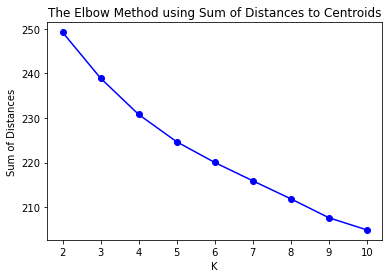

In [23]:
# Elbow method
ks = []
distances = []

for k in range(2, 11): # Change the upper bound to other value if necessary
    # Create a kmeans model on the data using k clusters
    kmeans_model = KMeans(n_clusters = k, random_state = 1).fit(embed)
    
    # Sum of distances to centroids
    distance = kmeans_model.inertia_
        
    # Store in a list
    ks.append(k)
    distances.append(distance)
    
# Plot distances
plt.plot(ks, distances, '-bo')
plt.xlabel('K')
plt.ylabel('Sum of Distances')
plt.title('The Elbow Method using Sum of Distances to Centroids')
plt.show()

Ideally, in the plot above, there should be an obvious change in the slope for 'Sum of Distances' curve around K = *number of lithological units*

### Example of reconstructed images

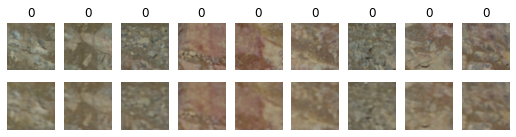

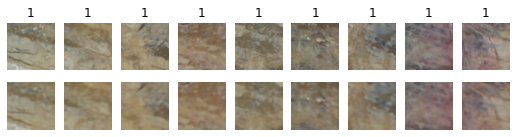

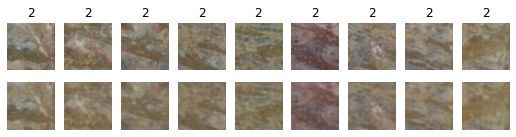

In [24]:
# Visualize subset
num_class = 3 # Change

# Cluster embedding layer
kmeans = KMeans(n_clusters = num_class, random_state = 1)
pred = kmeans.fit_predict(embed)

# Undo normalization 
transform_unnorm = transforms.Compose([transforms.Normalize(-mean/std, 1/std)])
im = transform_unnorm( iter(torch.utils.data.DataLoader(input_data, 
                                                         batch_size = len(input_data), 
                                                         shuffle = False)).next() )
recon = transform_unnorm(recon_output)

# Convert torch tensors to numpy (int)
im = im.cpu().detach().numpy().astype(int)
recon = recon.cpu().detach().numpy().astype(int)
classes = np.unique(pred) # Get the number of classes

# Show some original and reconstructed images
for cls in classes:
    plt.figure(figsize = (9, 2))
    indices = np.where(pred == cls)
    for i, item in enumerate(im[indices]):
        if i >= 9: break            
        plt.subplot(2, 9, i+1)
        plt.title(cls)
        plt.axis('off')
        plt.imshow(np.transpose(item, (1, 2, 0)))

    for i, item in enumerate(recon[indices]):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.axis('off')
        plt.imshow(np.transpose(item, (1, 2, 0)))

## Define the necessary functions to generate a lithology map

In [7]:
# Define a function to split the input raster into small tiles
def split_raster(in_raster, split_rows = 32, split_cols = 32, ):
    ''' This function splits ONE input raster into small tiles (type: numpy ndarray)
    
    Description:
        
        The raster will be split into small tiles, where each tile will have a dimension of split_rows*split_cols.
        The right-most columns and the bottom-most rows will be omitted i.e., Floor Division will be used.
        The horizontal span will be num_cols // split_cols, and the vertical span will be num_rows // split_rows.
     
    Arguments:
        
        in_raster: the input raster must have 3 channels (RGB) with sizes greater than split sizes 
        split_rows: the num of rows which the input raster will be split based on (each tile row will have this many pixels)
        split_cols: the num of cols which the input raster will be split based on (each tile col will have this many pixels)
        
    Returns:
        
        raster_data_dict: a dictionary containing the tile data and the image coordinate of the upper left corner of the tile
                          {"number_of_tiles"} -- a scalar that records how many tiles have been generated
                          {<tile index>} -- every tile index will have its sub-dictionary which includes:
                                         -- {'data'}: the splited raster data
                                         -- {'coordinate'}: the image plane coordinate of the upper left corner of the tile
        
    
    Author: Miller Tang
    Creation Date: June-06-2020
    Previous Edit: Jan-17-2022
    '''
    
    ## Step 1. Check the input raster and raise exception if it is not fulfilling the requirements
    if in_raster is None:
        raise Exception('The input is None. The input should be a raster with three channels.')
    
    # Determine the dimension/shape of the input raster
    d1, d2, d3 = in_raster.shape
    
    # Check whether the input raster is a three-channels raster data with either a channel-first or channel-last shape
    # If the raster is a channel-first raster, transpose the raster into a channel last format
    if d1 == 3:
        print("The input is a channel first raster array.")
        num_rows = d2
        num_cols = d3
        num_bands = d1
        
    elif d3 == 3:
        print("The input is a channel last raster array. \
Since we are using PyTorch models, we will convert it into channel-first raster.")
        num_rows = d1
        num_cols = d2
        num_bands = d3
        in_raster = in_raster.transpose(2,0,1)
    else:
        raise Exception("The input is neither a channel-first, \
nor a channel-last FOUR channels raster. Please check the input again.")
    del d1,d2,d3
    
    # Check if the input raster can be split into smaller tiles
    if (num_rows < split_rows): 
        raise Exception("The number of ROWS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_rows, split_rows))
    elif (num_cols < split_cols):
        raise Exception("The number of COLS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_cols, split_cols))
    
    ## Step 2: Determine how many tiles are in the horizontal and vertical directions
    tiles_hor = num_cols // split_cols # Horizontal span
    tiles_ver = num_rows // split_rows # Vertical span
    
    ## Step 3: Define a dictionary to store the tile data and the image plane location of the tile
    raster_data_dict = {}
    
    key_idx = 0 # Define a counter to be the key for each tile
    total_tiles = tiles_hor * tiles_ver # This is how many tiles will be generated
    
    raster_data_dict["number_of_tiles"] = total_tiles
    
    ## Step 4: Split the raster into small tiles and store them into a dictionary
    # Loop through the input raster to split it
    for i in range(tiles_ver): # First layer loop to loop throught the vertical direction
        for j in range(tiles_hor): # Second layer loop to loop throught the horizontal direction
            
            # Every key will have a sub-dictionary to record the data and the image plane coordinate of the upper left corner
            raster_data_dict[key_idx] = {}
            
            # Record the data into the corresponding sub-dictionary
            raster_data_dict[key_idx]['data'] = in_raster[:,i*split_rows:(i+1)*split_rows,j*split_cols:(j+1)*split_cols]
            raster_data_dict[key_idx]['coordinate'] = [i*split_rows, j*split_cols] # Coordinate of the upper left corner
            
            key_idx = key_idx + 1
                                                          
    # End of the two for loops to split data
    
    print("The data have been split and stored in the output.")
    
    return raster_data_dict

In [8]:
# Define a function to display the output lithology map tile by tile based on model prediction
def lithology_display_cluster(raster_data_dict, model, map_name, K_clusters = 5, title = None):
    ''' This function displays the predicted lithology mask using the model output
    
    Description:
    
        First, an embedding will be created for each orthomosaic tile by running it through the trained model. Second, the embeddings
        will be clustered and assigned a class each. Third, each orthomosaic tile will be coloured based on the class of the
        corresponding embedding.        
     
    Arguments:
        
        raster_data_dict: a dictionary contains the tile data and the image coordinate of the upper left corner of the tile
                          {"number_of_tiles"} -- a scalar that records how many tiles have been generated
                          {<tile index>} -- every tile index will have its sub-dictionary which includes:
                                         -- {'data'}: the splited raster data
                                         -- {'coordinate'}: the image plane coordinate of the upper left corner of the tile
        
        map_name: Name of the map
        model: the (trained) model used for mask prediction
        K_clusters: the number of cluster classes used for clustering
        title: the title of the the generated map
    
    Returns:
        
        lith_map: the generated lithology map
        
    
    Author: Miller Tang
    Creation Date: June-06-2020
    Previous Edit: Mar-7-2022
    
    '''
    
    ## Step 1: Extract the necessary variable values from the dictionary
    num_tiles = raster_data_dict['number_of_tiles']
    num_bands, split_rows, split_cols = raster_data_dict[0]['data'].shape
    end_coor_row, end_coor_col = raster_data_dict[num_tiles-1]['coordinate']
    end_coor_row += split_rows
    end_coor_col += split_cols
    
    # Allocate an empty mask space for the final map output
    lith_map = np.ones( (end_coor_row, end_coor_col) ) * (15) # A random initialization value
    
    ## Step 2: Loop through all the stored splitted-raster data inside the dictionary and make prediction using the model
    
    # Get the training data mean and std. dev and normalize the splitted-raster data by them
    data_arr, mean, std = load_and_preproc(norm = True) # Content of var data_arr not needed, so should be overwritten below
    transform_norm = transforms.Compose([transforms.Normalize(mean, std)])
    data_arr = np.asarray([raster_data_dict[idx]['data'] for idx in list(raster_data_dict.keys())[1:]]) # Np array [N, 3, H, W]
    data_arr = torch.tensor(data_arr).float()
    data_arr = transform_norm(data_arr) # Normalize by mean and std dev. of train data
    
    # Using an np array to store the embedding
    model.eval() # Set the model to evaluation mode
    embed_arr = []

    for idx in list(raster_data_dict.keys())[1:]: # Can change this loop to a torch DataLoader to allow faster batch computing
        embed_arr.append( model.encoder(data_arr[idx][None,...]).detach().cpu().numpy() )
        if (idx+1) % 5000 == 0:
            print("Has computed {} codes".format(idx+1))
    embed_arr = np.asarray(embed_arr).squeeze() # Np array [N, embed_dim]
    
    # Cluster embedding layer
    kmeans = KMeans(n_clusters = K_clusters, random_state = 1)
    pred = kmeans.fit_predict(embed_arr) # Np array [N,]
    
    ## Step 3: Create the mask/map
    clr_lib = ['red','blue','green','orange','purple','brown','pink','cyan','olive','gray','yellow'] # Colour library
    
    # Create an empty figure
    plt.figure(figsize = (15, 15))
    cmap = colors.ListedColormap(clr_lib[:K_clusters]+['white'])
    bounds = [-0.5 + i for i in range(K_clusters + 2)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = plt.imshow(lith_map, cmap = cmap, norm = norm)
    time.sleep(2) # Unit: [sec]
    
    
    # Loop through the K-mean predictions to create the mask/map
    for key_idx in list(raster_data_dict.keys())[1:]:
        coor_row, coor_col = raster_data_dict[key_idx]['coordinate'] # Extract the coordinate of the upper left corner
        
        # Update the lithology map values by using the predicted mask
        lith_map[coor_row: (coor_row + split_rows), coor_col: (coor_col + split_cols)] = \
        pred[key_idx]*np.ones((split_rows, split_cols)) #[H, W]

        # Step 3: Showing/plotting the update tile by tile
        # Update the figure every once in a while
        if (key_idx+1) % 800 == 0:
            
            clear_output(wait = True)
            
            if title is not None: # Determine whether a title is given
                plt.title(title)
        
            # Show the lithology map
            plt.figure(figsize = (15, 15))
            plt.imshow(lith_map, cmap = cmap, norm = norm)
            plt.axis('off')        
            plt.show()
            
            # Add a small delay after each iteration for image to show
            #time.sleep(0.4) # Unit: [sec]
            #clear_output(wait=True)
    
    # Ending the for loop for lithology map creation
    clear_output(wait = True)
    plt.figure(figsize = (15, 15))
    plt.imshow(lith_map, cmap = cmap, norm = norm)

    # Save the map (white is removed from cmap to ensure correct colour ordering in output file)
    plt.imsave(map_name + "{0}x{1}_K{2}_{3}.jpg".format(split_rows, split_cols, K_clusters, model.name), 
                                                                                       lith_map, 
                                                                                       cmap = \
               colors.ListedColormap(clr_lib[:K_clusters]))
    np.save(map_name + "{0}x{1}_K{2}_{3}_ndarray".format(split_rows, split_cols, K_clusters, model.name), lith_map)
    plt.axis('off')        
    plt.show()    

    return lith_map #, embed_arr   

In [36]:
##################################
# Model architectural parameters
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
in_shape = (3, 192, 192)
num_filters = 16
embed_dim = 128
seed = 888

# Hyperparameters
batch_size = 32
learning_rate = 0.0001

# Model architecture
model_name = 'PY'
##################################

if model_name == 'MT': # Model 1
    fpath = os.path.join(main_dir, 'Model_MT_Outputs') # Path of the output folder 
    model_final = Autoencoder_FConv(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)
elif model_name == 'PY': # Model 2
    fpath = os.path.join(main_dir, 'Model_PY_Outputs') # Path of the output folder 
    model_final = Autoencoder_FConv_Sym(in_shape = in_shape,
                       num_filters = num_filters,
                       embed_dim = embed_dim,
                       seed = seed)    
print('Using model', model_name)
print('Output directory:')
print(fpath)

Using model PY
Output directory:
D:\MASC Big Files\Data Processing\Deep Learning\Unsupervised Learning\Gold Bar\Pick Pit\2021_GB_Pick_E-Top\Model_PY_Outputs


In [37]:
# Final model
# REMEMBER TO MOVE THE NECESSARY FILES INTO THE SAME DIRECTORY WHERE THEY WERE INITIALLY SAVED 
params_file = fpath + '\Model_{0}_dim{1}_emb{2}_f{3}_s{4}_bs{5}_lr{6}{7}.pt'.format(model_final.name, 
                                                                             in_shape[-1], 
                                                                             embed_dim,  
                                                                             num_filters,  
                                                                             seed,  
                                                                             batch_size,
                                                                             learning_rate,
                                                                             suffix)

if use_cuda:
    model_final.load_state_dict( torch.load(params_file) ) 
else:
    device = torch.device('cpu')
    model_final.load_state_dict( torch.load(params_file, map_location = device) ) # Load params to CPU

model_final.eval() # Set to evaluation model for prediction at test time

Autoencoder_FConv_Sym(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(32, 64, kernel_size=(3, 3), str

In [38]:
# Load a full orthomosaic
# with Image.open(r'F:\Personal_Project\Lithology_Identification_Billy\2021_GB_Pick_E_Wall_orthomosaic.tif') as image:
#     arr = np.array(image)

# if no opencv2 installed then uncomment the above

##################################
# 2021_GB_Pick_E_Wall_orthomosaic_clipped_top
# 2021_BM_Top_orthomosaic_sample_clipped
ortho_file = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), r'orthomosaics\2021_GB_Pick_E_Wall_orthomosaic_clipped_top.tif')
row_dim = 192
col_dim = 192
##################################

import cv2
arr = cv2.imread(ortho_file)
arr = arr[...,::-1]
   
print(arr.shape)
print(type(arr))

raster_dic = split_raster(arr, split_rows = row_dim, split_cols = col_dim)
arr = None

(3371, 12118, 3)
<class 'numpy.ndarray'>
The input is a channel last raster array. Since we are using PyTorch models, we will convert it into channel-first raster.


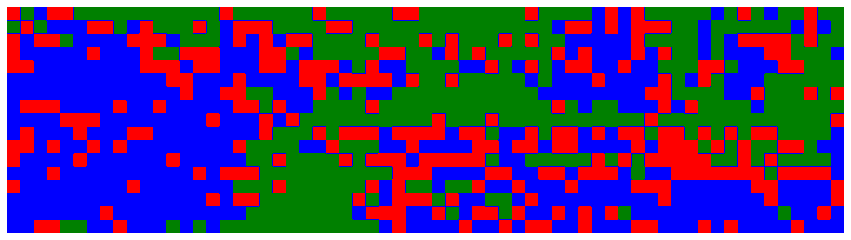

Time used: 46.43255829811096s


In [39]:
# Generate Map
##################################
K = 3
f_name = 'Pick_2021_Unsup_'
##################################

toc = time.time()
lith_map = lithology_display_cluster(raster_dic, 
                                 model_final, 
                                 K_clusters = K,  
                                 map_name = f_name)
print("Time used: {}s".format(time.time() - toc))
# Note that the outputs are saved in the same directory as this notebook

# Colour correction of lith maps & accuracy calculation

In [6]:
def postprocess_map(ground_truth_pth, lith_map_pth, unit_order, clr_lib, save = False):
    """
    Description: 
        Loads the ground truth map and the colour-uncorrected output lith map, and applies the colour ordering correction.
        Optionally, the maps and colour order can be saved.
    
    Args:
        ground_truth_pth: Directory path of the ground truth  (str)
        lith_map_pth: Directory path of the lith map (npy file) 
        unit_order: The colour ordering (list)
        clr_lib: The colour library used for visualization (list)
        save: Whether or not to save the maps (bool)
        
    Outputs:
        ground_truth_dict: Dictionary containing the label map, labels, and label counts (dict)
            {'label_map'} = The ground truth map just containing labels (np array)
            {'labels'} = The ground truth labels (np array)
            {'labels_count'} = Number of each label (np array)
        lith_map_dict: Dictionary containing the colour corrected lith map, cluster classes, and class counts (dict)
            {'lith_map_corr'} = The predicted lith map with colours corrected (np array)
            {'clust_grps'} = The cluster groups (np array)
            {'clust_grps_count'} = Number of each cluster group (np array)

    """
    
    # Load ground truth ortho, and also get the labels and their information
    with Image.open(ground_truth_pth) as image:
        ground_truth = np.array(image) # uint8 (H, W, C) where C = (R, G, B, label)   
        print('Dimensions & dtype of ground truth: ', ground_truth.shape, ground_truth.dtype)         
    label_map = ground_truth[..., -1] # (H, W, 1)
    labels, labels_count = np.unique(label_map, return_counts = True) # Labels start from 0 although it's not a lith unit 

    # Load predicted lith map (numpy file) and also get the cluster groups and their information
    lith_map  = np.load(lith_map_pth) # float (H, W) 
    if lith_map.dtype != ground_truth.dtype:
        lith_map = lith_map.astype(np.uint8) # Convert to uint8 from float
    clust_grps, clust_grps_count = np.unique(lith_map, 
                                            return_counts = True) # Labels start from 0 which COULD BE a lith unit
    print('Dimensions & dtype of lith map: ', lith_map.shape, lith_map.dtype)

    # Create mask
    lith_map_corr = np.zeros( (lith_map.shape[0], lith_map.shape[1]), dtype = np.uint8)
    assert lith_map_corr.shape == lith_map.shape, 'Dimensions are not the same' # Ensure dimensions are the same
    assert len(clust_grps) == len(unit_order), 'Total number of groups are not the same' # Ensure unit no. = cluster no.

    # Make the colour ordering correction
    for grp, unit in zip(clust_grps, unit_order):
        lith_map_corr[lith_map == grp] = unit    
    print('Current unit numbers: ', np.unique(lith_map_corr))
        
    # Save files
    if save:
        # Save the ground truth map
        cmap = colors.ListedColormap( (['white'] + clr_lib)[:labels[-1]+1] ) # Label 0 assigned as white
        plt.imsave(lith_map_pth.split('\\')[-1].split('_')[0] + '_' + lith_map_pth.split('\\')[-1].split('_')[1] + '_Ground_Truth_PY.jpg', 
                   label_map, 
                   cmap = cmap, dpi = 300)        
        # Save the corrected lith map
        cmap = colors.ListedColormap( clr_lib[:np.unique(lith_map_corr)[-1]] ) 
        plt.imsave(lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_corr.jpg', 
                   lith_map_corr, 
                   cmap = cmap) 
        # Save colour order
        with open(lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_order.txt', 'w') as f:
            f.write(str(unit_order))
        print('Files saved')            
        
    # Store map infos in dicts
    ground_truth_dict = dict( zip(('label_map', 'labels', 'labels_count'), (label_map, labels, labels_count)) )
    lith_map_dict = dict( zip(('lith_map_corr', 'clust_grps', 'clust_grps_count'), 
                              (lith_map_corr, clust_grps, clust_grps_count)) )

    return ground_truth_dict, lith_map_dict

In [11]:
###############################################################################################
###############################################################################################
# File paths
# 2021_BM_Top_orthomosaic_sample_clipped_truth_PY
# 2021_GB_Pick_E_Wall_clipped_top_truth_PY
gt_pth = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), '2021_GB_Pick_E_Wall_clipped_top_truth_PY.tif')
lm_pth = os.path.join(os.getcwd(), 'Npy files s5555 first', 'Pick_2021_Unsup_256x256_K3_PY_ndarray.npy')
# The corresponding lithological unit for each cluster group in a python List (manually change)
# Order may be saved in text file from previous runs
order = [0,1,2] # Given cluster group is [0, 1, 2, 3, ...] 

# Colouring of the units/groups
clr = ['blue','red','green','orange','purple','brown','pink','cyan','olive','gray','yellow'] 
###############################################################################################
###############################################################################################

gt_dict, lm_dict = postprocess_map(gt_pth, lm_pth, order, clr, save = True)

Dimensions & dtype of ground truth:  (3371, 12118, 4) uint8
Dimensions & dtype of lith map:  (3328, 12032) uint8
Current unit numbers:  [0 1 2]
Files saved


In [4]:
gt_pth = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), '2021_GB_Pick_E_Wall_clipped_top_truth_PY.tif')
lm_pth = os.path.join(os.getcwd(), 'Npy files s5555 first', 'Pick_2021_Unsup_256x256_K3_PY_ndarray.npy')
print(gt_pth)
print(lm_pth)

D:\MASC Big Files\Data Processing\2021_GB_Pick_E_Wall_clipped_top_truth_PY.tif
D:\MASC Big Files\Data Processing\Deep Learning\Unsupervised Learning\Npy files s5555 first\Pick_2021_Unsup_256x256_K3_PY_ndarray.npy


In [5]:
def other_metrics(y_true, y_pred, units, norms, pth):
    """
    Description: 
        Calculates other performance metrics other than accuracy such as precision, recall, F1, etc.
        Also creates confusion matrices.
    
    Args:
        y_true: The ground truth labels (Np array)
        y_pred: The predicted labels (Np array)
        units: The lith units (labels) (Np array)
        norms: Arguments for normalization parameter in confusion matrix (list of str)
        pth: Filename basis of the confusion matrix
        
    Outputs:
        None      
        
    """
    assert y_true.shape == y_pred.shape, 'True and pred are not the same size.' # (N, )
    
    # Create confusion matrices
    for norm in norms:
        print('Norm:', norm)
        confu_mat = confusion_matrix(y_true, y_pred, labels = units, normalize = norm)
        disp = ConfusionMatrixDisplay(confusion_matrix = confu_mat, display_labels = units)
        disp.plot(cmap = 'Blues')
        plt.show()
        disp.figure_.savefig( pth + '_' + str(norm) + '_cm.jpg' )
    
    # Compute precision, recall, F1, and support
    precision, recall, F1, support = precision_recall_fscore_support(y_true, y_pred, labels = units)
    
    # Print metrics
    for u, p, r, f, s in zip(units, precision, recall, F1, support):
        print('For Unit', u)
        print('Precision:', p)
        print('Recall:', r)
        print('F1 score:', f)
        print('Number of occurrences in ground truth:', s)
        print('\n')
    
    return

## Pixel-wise accuracy 

Adjusted label map dimensions:  (3328, 12032)
Norm: true


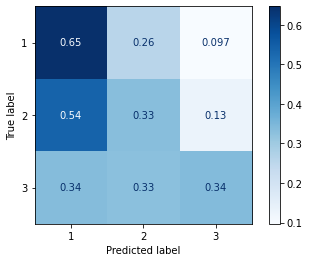

Norm: pred


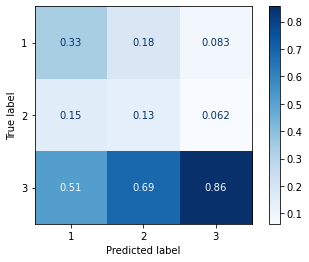

Norm: all


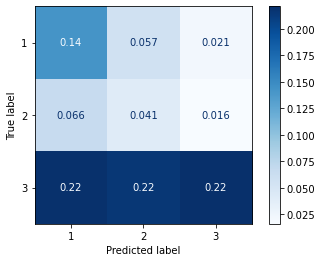

Norm: None


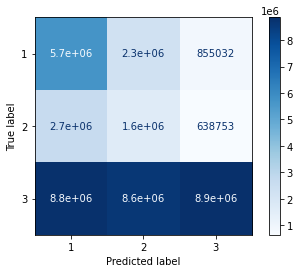

For Unit 1
Precision: 0.33256606473267536
Recall: 0.6462788761546387
F1 score: 0.4391511128775346
Number of occurrences in ground truth: 8835664


For Unit 2
Precision: 0.13047391082603893
Recall: 0.33144736874149155
F1 score: 0.18724071111506516
Number of occurrences in ground truth: 4927452


For Unit 3
Precision: 0.855738289748566
Recall: 0.3371808239007161
F1 score: 0.4837520637893668
Number of occurrences in ground truth: 26279380


Pixel-wise accuracy is 40.44% with 0.03% of upper margin
Pixel-wise accuracy just by guessing is 33.33%
Difference between the two accuracies: 7.11%


In [6]:
def pixel_acc(ground_truth_dict, lith_map_dict, lith_map_pth, other = False, save = False):
    """
    Description: 
        Calculates pixel-wise accuracy of the predicted lith map compared to the ground truth map as well as other metrics.
        Also saves an agreement-disagreement map showing where pixels do not match. 
    
    Args:
        ground_truth_dict: Dictionary containing the label map, labels, and label counts (dict)
            {'label_map'} = The ground truth map just containing labels (np array)
            {'labels'} = The ground truth labels (np array)
            {'labels_count'} = Number of each label (np array)
        lith_map_dict: Dictionary containing the colour corrected lith map, cluster classes, and class counts (dict)
            {'lith_map_corr'} = The predicted lith map with colours corrected (np array)
            {'clust_grps'} = The cluster groups (np array)
            {'clust_grps_count'} = Number of each cluster group (np array)
        lith_map_pth: Directory path of the lith map (just for file naming purposes)
        other: Whether or not to compute other metrics (bool)
        save: Whether or not to save the agreement-disagreement map (bool)
        
    Outputs:
        None      
        
    """
    
    # Unpack dictionary 
    label_map = ground_truth_dict['label_map']
    labels = ground_truth_dict['labels']
    lith_map_corr = lith_map_dict['lith_map_corr']
    
    # Adjust the label map dim to be the same as the lith map.
    # Since dims of label map is always greater than the lith map, 
    # the edges on the right side and bottom side are removed    
    label_map_adj = label_map[:lith_map_corr.shape[0], :lith_map_corr.shape[1]]
    print('Adjusted label map dimensions: ', label_map_adj.shape)
    agree_map = label_map_adj == lith_map_corr
    pix_acc = np.sum(agree_map) / (lith_map_corr.shape[0] * lith_map_corr.shape[1])

    # Since unit 0 in the label_map is not a lithological unit (no data place holder), the actual accuracy may be higher
    pix_acc_margin = label_map_adj[label_map_adj == labels[0]].shape[0] / (lith_map_corr.shape[0] * lith_map_corr.shape[1])

    # Calculate accuracy of randomly guessing the unit of a pixel
    pix_acc_guess = 1/len(labels[1:])
    
    # Calculate other performance metrics and confusion matrices
    if other:
        other_metrics(y_true = np.reshape(np.where(label_map_adj == 0, labels[1], label_map_adj), (-1,)), # Unit 0 replaced by next label
                      y_pred = np.reshape(lith_map_corr, (-1,)),
                      units = labels[1:], # Unit 0 excluded
                      norms = ['true', 'pred', 'all', None], # Scikit-learn normalization options   
                     pth = lith_map_pth.split('\\')[-1].replace('_ndarray.npy', ''))                
    
    # Save agreement map
    if save:
        plt.imsave(lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_agree.jpg', 
                   agree_map, 
                   cmap = 'Greys') # White = disagree

    print('Pixel-wise accuracy is {:.2f}% with {:.2f}% of upper margin'.format(pix_acc*100, pix_acc_margin*100))
    print('Pixel-wise accuracy just by guessing is {:.2f}%'.format(pix_acc_guess*100))
    print('Difference between the two accuracies: {:.2f}%'.format( (pix_acc - pix_acc_guess)*100) )
    
    return  

pixel_acc(gt_dict, lm_dict, lm_pth, other = True, save = True)

## Tile-wise accuracy

In [9]:
# Define a function to split the input raster into small tiles
def split_raster(in_raster, split_rows = 32, split_cols = 32, ):
    ''' This function splits ONE input raster into small tiles (type: numpy ndarray)
    
    Description:
        
        The raster will be split into small tiles, where each tile will have a dimension of split_rows*split_cols.
        The right-most columns and the bottom-most rows will be omitted i.e., Floor Division will be used.
        The horizontal span will be num_cols // split_cols, and the vertical span will be num_rows // split_rows.
     
    Arguments:
        
        in_raster: the input raster must have 3 channels (RGB) with sizes greater than split sizes 
        split_rows: the num of rows which the input raster will be split based on (each tile row will have this many pixels)
        split_cols: the num of cols which the input raster will be split based on (each tile col will have this many pixels)
        clr_lib: The colour library used for visualization (list)
    Returns:
        
        raster_data_dict: a dictionary containing the tile data and the image coordinate of the upper left corner of the tile
                          {"number_of_tiles"} -- a scalar that records how many tiles have been generated
                          {<tile index>} -- every tile index will have its sub-dictionary which includes:
                                         -- {'data'}: the splited raster data
                                         -- {'coordinate'}: the image plane coordinate of the upper left corner of the tile
        
    
    Author: Miller Tang
    Creation Date: June-06-2020
    Previous Edit: Jan-17-2022
    '''
    
    ## Step 1. Check the input raster and raise exception if it is not fulfilling the requirements
    if in_raster is None:
        raise Exception('The input is None. The input should be a raster with three channels.')
    
    # Determine the dimension/shape of the input raster
    d1, d2, d3 = in_raster.shape
    
    # Check whether the input raster is a three-channels raster data with either a channel-first or channel-last shape
    # If the raster is a channel-first raster, transpose the raster into a channel last format
    if d1 == 3:
        print("The input is a channel first raster array.")
        num_rows = d2
        num_cols = d3
        num_bands = d1
        
    elif d3 == 3:
        print("The input is a channel last raster array. \
Since we are using PyTorch models, we will convert it into channel-first raster.")
        num_rows = d1
        num_cols = d2
        num_bands = d3
        in_raster = in_raster.transpose(2,0,1)
    else:
        raise Exception("The input is neither a channel-first, \
nor a channel-last FOUR channels raster. Please check the input again.")
    del d1,d2,d3
    
    # Check if the input raster can be split into smaller tiles
    if (num_rows < split_rows): 
        raise Exception("The number of ROWS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_rows, split_rows))
    elif (num_cols < split_cols):
        raise Exception("The number of COLS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_cols, split_cols))
    
    ## Step 2: Determine how many tiles are in the horizontal and vertical directions
    tiles_hor = num_cols // split_cols # Horizontal span
    tiles_ver = num_rows // split_rows # Vertical span
    
    ## Step 3: Define a dictionary to store the tile data and the image plane location of the tile
    raster_data_dict = {}
    
    key_idx = 0 # Define a counter to be the key for each tile
    total_tiles = tiles_hor * tiles_ver # This is how many tiles will be generated
    
    raster_data_dict["number_of_tiles"] = total_tiles
    
    ## Step 4: Split the raster into small tiles and store them into a dictionary
    # Loop through the input raster to split it
    for i in range(tiles_ver): # First layer loop to loop throught the vertical direction
        for j in range(tiles_hor): # Second layer loop to loop throught the horizontal direction
            
            # Every key will have a sub-dictionary to record the data and the image plane coordinate of the upper left corner
            raster_data_dict[key_idx] = {}
            
            # Record the data into the corresponding sub-dictionary
            raster_data_dict[key_idx]['data'] = in_raster[:,i*split_rows:(i+1)*split_rows,j*split_cols:(j+1)*split_cols]
            raster_data_dict[key_idx]['coordinate'] = [i*split_rows, j*split_cols] # Coordinate of the upper left corner
            
            key_idx = key_idx + 1
                                                          
    # End of the two for loops to split data
    
    return raster_data_dict

In [10]:
def tile_acc(ground_truth_dict, lith_map_dict, rows, cols, clr_lib, lith_map_pth, other = False, save = False):
    """
    Description: 
        Calculates tile-wise accuracy of the predicted lith map compared to the ground truth map.
        Also, optionally saves an agreement-disagreement map showing where tiles do not match and the tiled ground truth map. 
    
    Args:
        ground_truth_dict: Dictionary containing the label map, labels, and label counts (dict)
            {'label_map'} = The ground truth map just containing labels (np array)
            {'labels'} = The ground truth labels (np array)
            {'labels_count'} = Number of each label (np array)
        lith_map_dict: Dictionary containing the colour corrected lith map, cluster classes, and class counts (dict)
            {'lith_map_corr'} = The predicted lith map with colours corrected (np array)
            {'clust_grps'} = The cluster groups (np array)
            {'clust_grps_count'} = Number of each cluster group (np array)
        rows: the num of rows which the input raster will be split based on (each tile row will have this many pixels)
        cols: the num of cols which the input raster will be split based on (each tile cols will have this many pixels)
        clr_lib: The colour library used for visualization (list)
        lith_map_pth: Directory path of the lith map (just for file naming purposes)
        other: Whether or not to compute other metrics (bool)
        save: Whether or not to save the agreement-disagreement map and tiled ground truth map(bool)
        
    Outputs:
        None      
        
    """
    
    # Get the maps
    label_map = ground_truth_dict['label_map']
    lith_map_corr = lith_map_dict['lith_map_corr']

    # Use split_raster function to split ground truth and lith map into tiles
    # Convert maps from (H, W) to (3, H, W) as required by split_raster function
    label_map_dict = \
    split_raster(np.repeat(label_map[ :lith_map_corr.shape[0], :lith_map_corr.shape[1] ][None, ...], repeats = 3, axis = 0),  
                                  split_rows = rows, 
                                  split_cols = cols) 
    lith_map_dict = \
    split_raster(np.repeat(lith_map_corr[None, ...], repeats = 3, axis = 0), split_rows = rows, split_cols = cols)
    assert label_map_dict['number_of_tiles'] == lith_map_dict['number_of_tiles'], 'Tile number is not the same'
    
    # Unpack dictionary from split_raster function output
    num_tiles = label_map_dict['number_of_tiles']
    end_coor_row, end_coor_col = label_map_dict[num_tiles-1]['coordinate']
    end_coor_row += rows
    end_coor_col += cols
    
    # Allocate an empty mask space for the agreement map and tiled ground truth output
    if save:
        tiled_gt_map = np.ones( (end_coor_row, end_coor_col) ) * (10) # A random initialization value
        agree_map = np.ones( (end_coor_row, end_coor_col) ) * (15) # A random initialization value
        assert agree_map.shape == (end_coor_row, end_coor_col), 'Agreement map is not the same size'
        
    # Loop through each tile in the label map to determine lith unit (using pixel majority) and compare to lith map
    tile_agree = 0
    y_true = []
    y_pred = []
    for key_idx in list(label_map_dict.keys())[1:]:
        tile = label_map_dict[key_idx]['data'][0] # (H, W) Only need 1 dim since the 3 dims are the same
        labels, label_count = np.unique(tile, return_counts = True) # Get the labels and their count in each tile
        assigned_label = labels[np.argmax(label_count)] # Label with the most pixels to assign to a ground truth tile
        if assigned_label == 0:
            assigned_label = labels[1:][ np.argmax(label_count[1:]) ] # Ignore label 0 and get the next largest
                                        
        # Change all labels to the the designated label and update the label map
        # From numpy manual: In case of multiple occurrences of the maximum values, 
        # the indices corresponding to the first occurrence are returned.
        tile_updated = np.where(tile != assigned_label, assigned_label, tile)
        assert np.all(tile_updated == assigned_label), 'Tile is not of a single label'
                
        # Update the agreement map and tiled ground truth map values
        if np.all(lith_map_dict[key_idx]['data'][0] == tile_updated):
            tile_agree += 1 # For calculating overall accuracy
        if save:
            coor_row, coor_col = label_map_dict[key_idx]['coordinate'] # Extract the coordinate of the upper left corner
            agree_map[coor_row: (coor_row + rows), coor_col: (coor_col + cols)] = lith_map_dict[key_idx]['data'][0] == tile_updated
            tiled_gt_map[coor_row: (coor_row + rows), coor_col: (coor_col + cols)] = tile_updated
        if other:
            y_true.append(assigned_label) # Keep track of the labels in each ground truth tile
            y_pred.append(lith_map_dict[key_idx]['data'][0].flat[0]) # Keep track of the labels in each lith map tile
                                        
    # Calculate other performance metrics and confusion matrices
    if other:
        other_metrics(y_true = np.array(y_true), # Convert list to Np array (N, )
                      y_pred = np.array(y_pred),
                      units = ground_truth_dict['labels'][1:], # Unit 0 excluded
                      norms = ['true', 'pred', 'all', None], # Scikit-learn normalization options 
                     pth = lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_tiled')    
        
    # Calculate overall accuracy
    tile_acc = tile_agree / num_tiles
    
    # Calculate accuracy of randomly guessing the unit of a tile
    tile_acc_guess = 1/len(ground_truth_dict['labels'][1:]) # Unit 0 excluded
    
    # Save tiled ground truth map and agreement map
    if save:
        cmap = colors.ListedColormap( clr_lib[ :ground_truth_dict['labels'][-1] ] )                             
        plt.imsave(lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_gt_tiled.jpg', tiled_gt_map, cmap = cmap)                                
        plt.imsave(lith_map_pth.split('\\')[-1].replace('_ndarray.npy', '') + '_agree_tiled.jpg', agree_map, cmap = 'Greys') # White = disagree

    print('Tile-wise accuracy is {:.2f}%'.format(tile_acc*100))
    print('Tile-wise accuracy just by guessing is {:.2f}%'.format(tile_acc_guess*100))
    print('Difference between the two accuracies: {:.2f}%'.format( (tile_acc - tile_acc_guess)*100) )
    
    return   

The input is a channel first raster array.
The input is a channel first raster array.
Norm: true


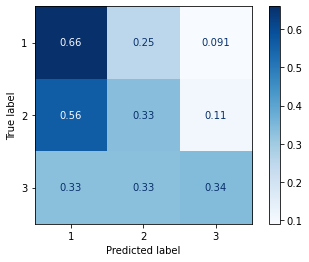

Norm: pred


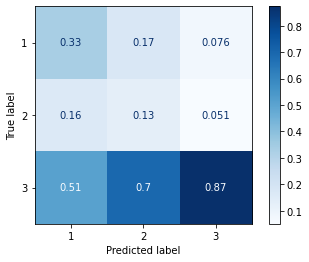

Norm: all


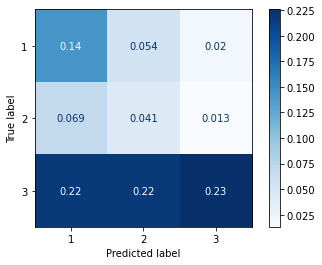

Norm: None


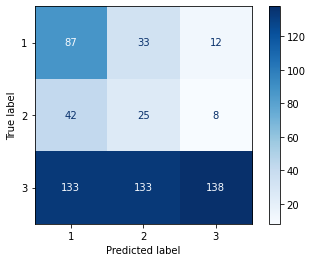

For Unit 1
Precision: 0.3320610687022901
Recall: 0.6590909090909091
F1 score: 0.4416243654822335
Number of occurrences in ground truth: 132


For Unit 2
Precision: 0.13089005235602094
Recall: 0.3333333333333333
F1 score: 0.18796992481203006
Number of occurrences in ground truth: 75


For Unit 3
Precision: 0.8734177215189873
Recall: 0.3415841584158416
F1 score: 0.49110320284697506
Number of occurrences in ground truth: 404


Tile-wise accuracy is 40.92%
Tile-wise accuracy just by guessing is 33.33%
Difference between the two accuracies: 7.58%


In [11]:
tile_acc(ground_truth_dict = gt_dict, 
         lith_map_dict = lm_dict, 
         rows = 256, 
         cols = 256, 
         clr_lib = clr, 
         lith_map_pth = lm_pth,
         other = True,
         save = True)